### Imports & setup

In [1]:
# Core
from pathlib import Path
import os, sys, json, re, math, random
import pandas as pd
from tqdm.auto import tqdm

# Opsional untuk baca metadata video
import cv2  # sudah tersedia di Kaggle

In [2]:
# Temukan folder dataset di /kaggle/input
INPUT_DIR = Path("/kaggle/input")

candidates = sorted([p for p in INPUT_DIR.glob("deep-fake-detection-dfd*") if p.is_dir()])
assert len(candidates) >= 1, "Folder dataset DFD tidak ditemukan di /kaggle/input"
BASE = candidates[0]
BASE

PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset')

In [3]:
# Lokasi real vs fake. Dua folder ini ada di root dataset
DIR_FAKE = next(p for p in BASE.iterdir() if "manipulated" in p.name.lower())
DIR_REAL = next(p for p in BASE.iterdir() if "original" in p.name.lower())

DIR_FAKE, DIR_REAL

(PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences'),
 PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences'))

In [4]:
# Kumpulkan daftar file video
# Ekstensi umum untuk video di dataset riset
VIDEO_EXTS = (".mp4", ".avi", ".mov", ".mkv")

def list_videos(root: Path):
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in VIDEO_EXTS])

fake_videos = list_videos(DIR_FAKE)
real_videos = list_videos(DIR_REAL)

print(f"FAKE : {len(fake_videos):,} files")
print(f"REAL : {len(real_videos):,} files")

# intip 3 contoh
fake_videos[:3], real_videos[:3]

FAKE : 3,068 files
REAL : 363 files


([PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__exit_phone_room__YVGY8LOK.mp4'),
  PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__hugging_happy__YVGY8LOK.mp4'),
  PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_02__meeting_serious__YVGY8LOK.mp4')],
 [PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/01__exit_phone_room.mp4'),
  PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/01__hugging_happy.mp4'),
  PosixPath('/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/01__kitchen_pan.mp4')])

In [5]:
# Bangun DataFrame: path + label (+ sedikit metadata opsional)
def video_meta(path: Path):
    """Cepat: hanya ambil (w,h,fps,frames,duration_s). Kalau gagal, isi None."""
    try:
        cap = cv2.VideoCapture(str(path))
        if not cap.isOpened():
            return None, None, None, None, None
        fps    = cap.get(cv2.CAP_PROP_FPS) or 0
        frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        w      = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
        h      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
        dur    = frames / fps if fps else None
        cap.release()
        return w, h, fps, frames, dur
    except Exception:
        return None, None, None, None, None

def build_df(paths, label):
    rows = []
    for p in paths:
        # opsional: turunkan subject / method dari struktur folder
        parts = p.relative_to(BASE).parts
        method = next((x for x in parts if re.search(r"(deepfake|faceswap|dfd|manip|original)", x, re.I)), None)
        subject = parts[-2] if len(parts) >= 2 else None

        w,h,fps,frames,dur = video_meta(p)  # boleh dimatikan jika lambat
        rows.append(dict(
            filepath=str(p),
            label=label,                # "FAKE" / "REAL"
            method=method,
            subject=subject,
            width=w, height=h, fps=fps, frames=frames, duration_s=dur
        ))
    return rows

df = pd.DataFrame(build_df(fake_videos, "FAKE") + build_df(real_videos, "REAL"))
df.head()

,filepath,label,method,subject,width,height,fps,frames,duration_s
0,/kaggle/input/deep-fake-detection-dfd-entire-o...,FAKE,DFD_manipulated_sequences,DFD_manipulated_sequences,1920,1080,24.0,210,8.750000
1,/kaggle/input/deep-fake-detection-dfd-entire-o...,FAKE,DFD_manipulated_sequences,DFD_manipulated_sequences,1920,1080,24.0,578,24.083333
2,/kaggle/input/deep-fake-detection-dfd-entire-o...,FAKE,DFD_manipulated_sequences,DFD_manipulated_sequences,1920,1080,24.0,1044,43.500000
3,/kaggle/input/deep-fake-detection-dfd-entire-o...,FAKE,DFD_manipulated_sequences,DFD_manipulated_sequences,1920,1080,24.0,727,30.291667
4,/kaggle/input/deep-fake-detection-dfd-entire-o...,FAKE,DFD_manipulated_sequences,DFD_manipulated_sequences,1920,1080,24.0,905,37.708333


In [6]:
# Sanity check cepat terkait width, height, fps.
print(df['label'].value_counts(dropna=False))
print(df[['width','height','fps']].describe())

# Simpan untuk dipakai training nanti
OUT_CSV = Path("/kaggle/working/dfd_index.csv")
df.to_csv(OUT_CSV, index=False)
OUT_CSV

label
FAKE    3068
REAL     363
Name: count, dtype: int64
        width  height     fps
count  3431.0  3431.0  3431.0
mean   1920.0  1080.0    24.0
std       0.0     0.0     0.0
min    1920.0  1080.0    24.0
25%    1920.0  1080.0    24.0
50%    1920.0  1080.0    24.0
75%    1920.0  1080.0    24.0
max    1920.0  1080.0    24.0


PosixPath('/kaggle/working/dfd_index.csv')

/tmp/ipykernel_36/1038904593.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(2, len(g)), random_state=42))


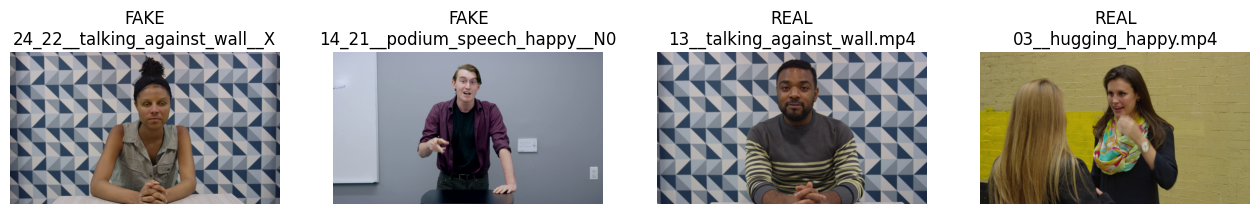

In [7]:
# Ambil beberapa frame untuk visual check
import numpy as np
from matplotlib import pyplot as plt

def read_frame_at(path, ratio=0.5):
    cap = cv2.VideoCapture(str(path))
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    idx = int(total * ratio) if total > 0 else 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ok, frame = cap.read()
    cap.release()
    if not ok: return None
    # BGR -> RGB
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

sample_rows = (
    df.groupby('label', group_keys=False)
      .apply(lambda g: g.sample(min(2, len(g)), random_state=42))
      .reset_index(drop=True)
)

fig, axes = plt.subplots(1, len(sample_rows), figsize=(4*len(sample_rows), 4))
if len(sample_rows) == 1: axes = [axes]
for ax, (_, r) in zip(axes, sample_rows.iterrows()):
    img = read_frame_at(r['filepath'], ratio=0.5)
    ax.imshow(img if img is not None else np.zeros((64,64,3), dtype=np.uint8))
    ax.set_title(f"{r['label']}\n{Path(r['filepath']).name[:30]}")
    ax.axis("off")
plt.show()


### Ekstrak dan lihat 3 skema sampling dari 10+10 video : uniform 8 frame per video, uniform 16 frame, clip 2 detik dari tengah (8 frame).

Tampilkan grid
visual check apakah wajah konsisten muncul, apakah frame terlalu mirip, atau malah ada noise.

In [8]:
from pathlib import Path
import cv2, math, numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import random, warnings

random.seed(42); np.random.seed(42)

def open_cap(path):
    cap = cv2.VideoCapture(str(path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open {path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 0
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    return cap, fps, frames

def read_frame_idx(cap, idx):
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
    ok, fr = cap.read()
    if not ok: return None
    return cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)

def sample_uniform_indices(n_frames, k):
    if n_frames == 0: return []
    # pilih k titik tersebar (inklusif 0 & n-1)
    return [min(int(round(i*(n_frames-1)/(k-1))), n_frames-1) for i in range(k)]

def sample_mid_clip_indices(n_frames, fps, seconds=2.0, k=8):
    if fps and fps>0:
        need = int(seconds * fps)
    else:
        need = max(k, 8)  # fallback
    if n_frames <= need:
        # kalau video pendek, pakai uniform aja
        return sample_uniform_indices(n_frames, min(k, max(1, n_frames)))
    start = max(0, (n_frames - need)//2)
    end = start + need
    # ambil k index merata di jendela tengah
    span = list(range(start, end))
    if k >= len(span): return span
    return [span[min(int(round(i*(len(span)-1)/(k-1))), len(span)-1)] for i in range(k)]

def grab_frames(path, indices):
    cap, fps, total = open_cap(path)
    frames = []
    for idx in indices:
        img = read_frame_idx(cap, idx)
        if img is not None:
            frames.append(img)
    cap.release()
    return frames

def show_grid(sample_rows, scheme_name, k_per_video):
    cols = k_per_video
    rows = len(sample_rows)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.4, rows*2.4))
    if rows==1: axes = np.expand_dims(axes,0)
    for r, (_, row) in enumerate(sample_rows.iterrows()):
        path = row['filepath']
        title = f"{row['label']} — {Path(path).name[:28]}"
        try:
            cap, fps, total = open_cap(path)
            if scheme_name=="uniform8":
                idxs = sample_uniform_indices(total, min(8, max(1,total)))
            elif scheme_name=="uniform16":
                idxs = sample_uniform_indices(total, min(16, max(1,total)))
            elif scheme_name=="midclip2s":
                idxs = sample_mid_clip_indices(total, fps, seconds=2.0, k=8)
            else:
                idxs = sample_uniform_indices(total, min(8, max(1,total)))
            imgs = []
            for i, idx in enumerate(idxs):
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ok, fr = cap.read()
                if not ok: imgs.append(None); continue
                fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
                imgs.append(fr)
            cap.release()
            # plot
            for c in range(cols):
                ax = axes[r, c]
                if c < len(imgs) and imgs[c] is not None:
                    ax.imshow(imgs[c])
                ax.axis("off")
                if c==0:
                    ax.set_title(title, fontsize=9)
        except Exception as e:
            for c in range(cols):
                ax = axes[r,c]
                ax.text(0.5,0.5,str(e)[:40],ha='center',va='center')
                ax.axis("off")
    plt.suptitle(f"Scheme: {scheme_name}", y=0.99)
    plt.tight_layout()
    plt.show()


In [9]:
# pastikan df sudah ada
assert {'filepath','label'}.issubset(df.columns)

target_per_class = 10
subset = (
    df.groupby('label', group_keys=False)
      .apply(lambda g: g.sample(min(target_per_class, len(g)), random_state=42))
      .reset_index(drop=True)
)

subset['label'].value_counts()
subset.head(2)


/tmp/ipykernel_36/1272795271.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(target_per_class, len(g)), random_state=42))


,filepath,label,method,subject,width,height,fps,frames,duration_s
0,/kaggle/input/deep-fake-detection-dfd-entire-o...,FAKE,DFD_manipulated_sequences,DFD_manipulated_sequences,1920,1080,24.0,1081,45.041667
1,/kaggle/input/deep-fake-detection-dfd-entire-o...,FAKE,DFD_manipulated_sequences,DFD_manipulated_sequences,1920,1080,24.0,1320,55.000000


In [10]:
# # Skema 1: uniform 8 frame per video
# show_grid(subset, scheme_name="uniform8",  k_per_video=8)

# # Skema 2: uniform 16 frame per video
# show_grid(subset, scheme_name="uniform16", k_per_video=16)

# # Skema 3: mid-clip 2 detik (tampilkan 8 frame)
# show_grid(subset, scheme_name="midclip2s", k_per_video=8)


### Pilih mid 2s (8 frame)

In [11]:
# Setup & utility
from pathlib import Path
import os, re, math, random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import cv2

random_state = 42
random.seed(random_state); np.random.seed(random_state)

OUT_ROOT = Path("/kaggle/working/frames_midclip2s")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

assert {'filepath','label','fps','frames'}.issubset(df.columns), "Kolom df tidak lengkap"


In [12]:
# Stratified split per-video
# rasio bisa diubah: 0.8/0.1/0.1
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=random_state
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=random_state
)

for name, part in [('train',train_df), ('val',val_df), ('test',test_df)]:
    print(name, part['label'].value_counts().to_dict())

# simpan index split (berguna untuk reproduksi)
split_index_path = Path("/kaggle/working/dfd_splits.csv")
pd.concat([
    train_df.assign(split='train'),
    val_df.assign(split='val'),
    test_df.assign(split='test')
]).to_csv(split_index_path, index=False)
split_index_path


train {'FAKE': 2454, 'REAL': 290}
val {'FAKE': 307, 'REAL': 36}
test {'FAKE': 307, 'REAL': 37}


PosixPath('/kaggle/working/dfd_splits.csv')

In [13]:
# Sampler mid-clip 2s (8 frame)
def open_cap(path):
    cap = cv2.VideoCapture(str(path))
    if not cap.isOpened():
        return None, 0.0, 0
    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    return cap, fps, frames

def midclip_indices(n_frames, fps, seconds=2.0, k=8):
    if n_frames <= 0:
        return []
    need = int(seconds * fps) if fps and fps>0 else max(k, 8)
    if n_frames <= need:  # kalau video pendek, sebar merata
        # k disesuaikan supaya tidak melebihi jumlah frame
        k_eff = min(k, n_frames)
        return [min(int(round(i*(n_frames-1)/(k_eff-1))), n_frames-1) for i in range(k_eff)]
    start = max(0, (n_frames - need)//2)
    end = start + need
    span = list(range(start, end))
    if k >= len(span): 
        return span
    return [span[min(int(round(i*(len(span)-1)/(k-1))), len(span)-1)] for i in range(k)]

def safe_stem(path_str):
    # buat nama folder aman
    s = Path(path_str).stem
    return re.sub(r'[^a-zA-Z0-9_\-]+', '_', s)[:80]


## Ektraksi video ke frame sebagai JPG (mid2s 8 frame)

In [14]:
def extract_split(part_df, split_name, seconds=2.0, k=8, resize_to=(224,224)):
    rows = []
    out_dir = OUT_ROOT / split_name
    for _, r in tqdm(part_df.iterrows(), total=len(part_df), desc=f"Extract {split_name}"):
        vid_path = r['filepath']
        label = r['label']
        cap, fps, total = open_cap(vid_path)
        if cap is None:
            # catat gagal
            rows.append(dict(split=split_name, filepath=vid_path, label=label, saved=0, note='open_fail'))
            continue

        idxs = midclip_indices(total, fps, seconds=seconds, k=k)
        save_dir = out_dir / label / safe_stem(vid_path)
        save_dir.mkdir(parents=True, exist_ok=True)

        saved = 0
        for j, idx in enumerate(idxs):
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
            ok, fr = cap.read()
            if not ok:
                continue
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            if resize_to:
                fr = cv2.resize(fr, resize_to, interpolation=cv2.INTER_AREA)
            # simpan sebagai RGB JPG
            cv2.imwrite(str(save_dir / f"f{j:02d}.jpg"), cv2.cvtColor(fr, cv2.COLOR_RGB2BGR))
            saved += 1
        cap.release()

        rows.append(dict(split=split_name, filepath=vid_path, label=label, fps=fps, frames=total, saved=saved, out_dir=str(save_dir)))
    return pd.DataFrame(rows)

# jalanan
log_train = extract_split(train_df, 'train', seconds=2.0, k=8, resize_to=None)
log_val   = extract_split(val_df,   'val',   seconds=2.0, k=8, resize_to=None)
log_test  = extract_split(test_df,  'test',  seconds=2.0, k=8, resize_to=None)

log_all = pd.concat([log_train, log_val, log_test], ignore_index=True)
log_path = Path("/kaggle/working/extract_log_midclip2s.csv")
log_all.to_csv(log_path, index=False)
log_all.head(), log_path


Extract train:   0%|          | 0/2744 [00:00<?, ?it/s]

Extract val:   0%|          | 0/343 [00:00<?, ?it/s]

Extract test:   0%|          | 0/344 [00:00<?, ?it/s]

(   split                                           filepath label   fps  \
 0  train  /kaggle/input/deep-fake-detection-dfd-entire-o...  FAKE  24.0   
 1  train  /kaggle/input/deep-fake-detection-dfd-entire-o...  FAKE  24.0   
 2  train  /kaggle/input/deep-fake-detection-dfd-entire-o...  FAKE  24.0   
 3  train  /kaggle/input/deep-fake-detection-dfd-entire-o...  FAKE  24.0   
 4  train  /kaggle/input/deep-fake-detection-dfd-entire-o...  FAKE  24.0   
 
    frames  saved                                            out_dir  
 0     481      8  /kaggle/working/frames_midclip2s/train/FAKE/04...  
 1     976      8  /kaggle/working/frames_midclip2s/train/FAKE/12...  
 2     836      8  /kaggle/working/frames_midclip2s/train/FAKE/15...  
 3     817      8  /kaggle/working/frames_midclip2s/train/FAKE/03...  
 4     616      8  /kaggle/working/frames_midclip2s/train/FAKE/14...  ,
 PosixPath('/kaggle/working/extract_log_midclip2s.csv'))

## Crop wajah + resize 224 ke folder baru.

### Tahap 2: ambil JPG hasil mid-clip → face-crop + resize + pad ke T=8 → simpan ke folder baru.

In [15]:
# === Face-crop dari 8 frame → 224x224 ===
from pathlib import Path
import cv2, glob, re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

SRC_ROOT  = Path("/kaggle/working/frames_midclip2s")        # dari langkah sebelumnya
DEST_ROOT = Path("/kaggle/working/faces_from_frames_224")   # tujuan baru
DEST_ROOT.mkdir(parents=True, exist_ok=True)

K_TARGET = 8
OUT_SIZE = (224, 224)
JPEG_QUALITY = 95
MARGIN = 0.20  # margin bbox 20%

# detector wajah (bawaan OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def safe_name(p): 
    return re.sub(r'[^a-zA-Z0-9_\-]+', '_', Path(p).stem)[:80]

def detect_face_bgr(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(60,60))
    if len(faces)==0: 
        return None  # (x,y,w,h)
    # pilih wajah terbesar
    return max(faces, key=lambda b: b[2]*b[3])

def clamp(x0,y0,x1,y1,w,h):
    x0 = max(0, min(x0, w-1)); y0 = max(0, min(y0, h-1))
    x1 = max(0, min(x1, w));   y1 = max(0, min(y1, h))
    if x1 <= x0: x1 = min(w, x0+1)
    if y1 <= y0: y1 = min(h, y0+1)
    return x0,y0,x1,y1

def anchor_bbox(frames_bgr, margin=MARGIN):
    """Hitung bbox wajah yang stabil antar-frame (median). Fallback: center square."""
    H=W=None; boxes=[]
    for im in frames_bgr:
        if im is None: continue
        if H is None: H,W = im.shape[:2]
        det = detect_face_bgr(im)
        if det is not None:
            x,y,w,h = det
            cx, cy = x+w/2, y+h/2
            s = max(w,h)
            boxes.append((cx,cy,s))
    if not boxes:
        s = min(H,W)
        x0=(W-s)//2; y0=(H-s)//2
        return clamp(x0,y0,x0+s,y0+s,W,H)
    boxes = np.array(boxes)
    cx,cy,s = np.median(boxes, axis=0)
    s = s*(1.0+margin*2)  # tambah margin
    x0=int(round(cx - s/2)); y0=int(round(cy - s/2))
    x1=int(round(cx + s/2)); y1=int(round(cy + s/2))
    return clamp(x0,y0,x1,y1,W,H)

def process_video_dir(src_dir: Path, dest_dir: Path):
    frames = sorted(glob.glob(str(src_dir/"*.jpg")))
    if len(frames)==0:
        return 0, "no_frames"
    # sudah diproses?
    if (dest_dir/"f00.jpg").exists():
        return K_TARGET, "skip_exists"

    # baca semua (BGR)
    imgs = [cv2.imread(fp) for fp in frames[:K_TARGET]]
    imgs = [im for im in imgs if im is not None]
    if len(imgs)==0:
        return 0, "read_fail"

    x0,y0,x1,y1 = anchor_bbox(imgs)

    dest_dir.mkdir(parents=True, exist_ok=True)
    saved=0; last=None
    for j in range(min(len(imgs), K_TARGET)):
        crop = imgs[j][y0:y1, x0:x1]
        crop = cv2.resize(crop, OUT_SIZE, interpolation=cv2.INTER_AREA)
        last = crop
        cv2.imwrite(str(dest_dir/f"f{j:02d}.jpg"), crop, [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_QUALITY])
        saved += 1
    while saved < K_TARGET and last is not None:
        cv2.imwrite(str(dest_dir/f"f{saved:02d}.jpg"), last, [int(cv2.IMWRITE_JPEG_QUALITY), JPEG_QUALITY])
        saved += 1
    return saved, "ok"

def convert_split(split_name):
    src_split  = SRC_ROOT / split_name
    dest_split = DEST_ROOT / split_name
    stats=[]
    for label in ["FAKE","REAL"]:
        for vid_dir in sorted((src_split/label).glob("*")):
            if not vid_dir.is_dir(): 
                continue
            out_dir = dest_split/label/vid_dir.name
            saved, note = process_video_dir(vid_dir, out_dir)
            stats.append((split_name, label, vid_dir.name, saved, note))
    return stats

# --- jalankan semua split ---
all_stats=[]
for sp in ["train","val","test"]:
    all_stats.extend(convert_split(sp))

# log ringkas
log_faces = pd.DataFrame(all_stats, columns=["split","label","video_dir","saved","note"])
log_faces.to_csv("/kaggle/working/face_from_frames_log.csv", index=False)
log_faces['note'].value_counts(), log_faces.head()


(note
 ok    3431
 Name: count, dtype: int64,
    split label                                        video_dir  saved note
 0  train  FAKE                 01_02__exit_phone_room__YVGY8LOK      8   ok
 1  train  FAKE                 01_02__meeting_serious__YVGY8LOK      8   ok
 2  train  FAKE  01_02__outside_talking_still_laughing__YVGY8LOK      8   ok
 3  train  FAKE            01_02__talking_against_wall__YVGY8LOK      8   ok
 4  train  FAKE             01_02__talking_angry_couch__YVGY8LOK      8   ok)

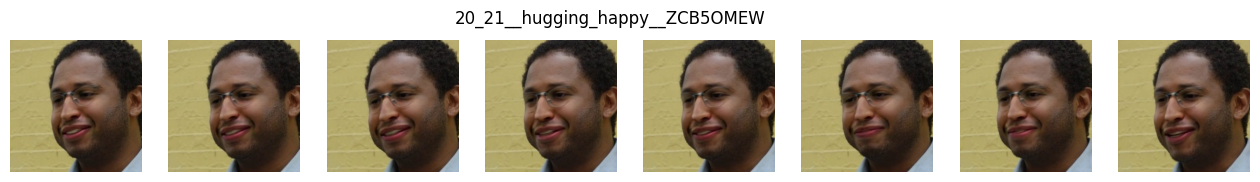

In [16]:
# lihat 1 sample dari val/FAKE
import random, matplotlib.pyplot as plt
sample_dir = next((DEST_ROOT/"val"/"FAKE").glob("*"))
frames = sorted(glob.glob(str(sample_dir/"*.jpg")))[:8]
plt.figure(figsize=(16,2))
for i,p in enumerate(frames):
    plt.subplot(1,8,i+1); plt.imshow(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.suptitle(sample_dir.name); plt.show()

## (Baseline) EfficientNet-B0 per-frame → BiGRU(256)

In [19]:
# Dataset & DataLoader
from pathlib import Path
import glob, os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

ROOT = Path("/kaggle/working/faces_from_frames_224")
T = 8  # jumlah frame per video

IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD  = [0.229, 0.224, 0.225]

class FaceClipDataset(Dataset):
    def __init__(self, root, split, t=T):
        self.root = Path(root)/split
        self.t = t
        self.items = []  # (frames_dir, label_int)
        for label in ["FAKE","REAL"]:
            for vid_dir in sorted((self.root/label).glob("*")):
                if vid_dir.is_dir():
                    self.items.append((vid_dir, 0 if label=="FAKE" else 1))
        # augment ringan (opsional): horizontal flip kecil
        self.tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(IMG_MEAN, IMG_STD),
        ])
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        vdir, y = self.items[idx]
        frames = sorted(glob.glob(str(vdir/"*.jpg")))[:self.t]
        while len(frames) < self.t:  # jaga-jaga
            frames.append(frames[-1])
        imgs = [self.tf(Image.open(f).convert("RGB")) for f in frames]
        x = torch.stack(imgs, dim=0)   # [T,3,224,224]
        return x, torch.tensor([y], dtype=torch.float32)

train_set = FaceClipDataset(ROOT, 'train', t=T)
val_set   = FaceClipDataset(ROOT, 'val',   t=T)
test_set  = FaceClipDataset(ROOT, 'test',  t=T)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

len(train_set), len(val_set), len(test_set)


(2744, 343, 344)

In [20]:
# Model: EfficientNet-B0 (frozen dulu) + BiGRU

import torch, torch.nn as nn, torchvision
from torchvision.models import EfficientNet_B0_Weights

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_efficientnet_b0_try_pretrained():
    try:
        m = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    except Exception:
        m = torchvision.models.efficientnet_b0(weights=None)
    return m

class FrameEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        m = build_efficientnet_b0_try_pretrained()
        self.features = m.features
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        for p in self.features.parameters():  # freeze awal
            p.requires_grad = False
    def forward(self, x):                     # [B,3,224,224]
        f = self.features(x)
        f = self.pool(f).flatten(1)           # [B,1280]
        return f

class EffB0_BiGRU(nn.Module):
    def __init__(self, hidden=256, bidirectional=True):
        super().__init__()
        self.enc = FrameEncoder()
        self.gru = nn.GRU(1280, hidden, batch_first=True, bidirectional=bidirectional)
        out_dim = hidden*(2 if bidirectional else 1)
        self.drop = nn.Dropout(0.2)
        self.fc = nn.Linear(out_dim, 1)
    def forward(self, x):                     # x: [B,T,3,224,224]
        B,T = x.shape[:2]
        x = x.view(B*T, 3, 224, 224)
        f = self.enc(x)                       # [B*T,1280]
        f = f.view(B, T, -1)                  # [B,T,1280]
        _, h = self.gru(f)                    # h: [layers*dir,B,H]
        h = torch.cat([h[-2], h[-1]], dim=1) if self.gru.bidirectional else h[-1]
        z = self.drop(h)
        logit = self.fc(z).squeeze(1)         # [B]
        return logit

model = EffB0_BiGRU().to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 164MB/s]


In [24]:
# Training util + logging + scheduler

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

# class weight -> pos_weight untuk BCEWithLogits
y_train = np.array([lbl.item() for _,lbl in DataLoader(train_set, batch_size=1)])
w = compute_class_weight('balanced', classes=np.array([0,1]), y=y_train.astype(int))
pos_weight = torch.tensor(w[1]/w[0], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def make_optimizer(lr): 
    return torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=1e-4)
optimizer = make_optimizer(2e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

def run_epoch(loader, train=True):
    model.train(train)
    losses=[]; probs_all=[]; y_all=[]
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        y = y.squeeze(1).to(device, non_blocking=True)
        with torch.set_grad_enabled(train):
            logit = model(x)
            loss = criterion(logit, y)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        losses.append(loss.item())
        probs = torch.sigmoid(logit).detach().cpu().numpy()
        probs_all.append(probs); y_all.append(y.detach().cpu().numpy())
    probs_all = np.concatenate(probs_all); y_all = np.concatenate(y_all)
    preds = (probs_all>=0.5).astype(int)
    f1 = f1_score(y_all, preds)
    try: auc = roc_auc_score(y_all, probs_all)
    except: auc = float('nan')
    return float(np.mean(losses)), float(f1), float(auc)

# logging
hist = {'tr_loss':[], 'va_loss':[], 'tr_f1':[], 'va_f1':[], 'tr_auc':[], 'va_auc':[]}
best = {'auc': -1, 'state': None}

Epoch 01 | train loss 0.8443 f1 0.423 auc 0.858  ||  val loss 1.1075 f1 0.362 auc 0.805
Epoch 02 | train loss 0.8187 f1 0.433 auc 0.867  ||  val loss 0.8799 f1 0.450 auc 0.849
Epoch 03 | train loss 0.8413 f1 0.417 auc 0.861  ||  val loss 0.8840 f1 0.341 auc 0.832
Epoch 04 | train loss 0.6175 f1 0.521 auc 0.926  ||  val loss 0.8812 f1 0.385 auc 0.838
Epoch 05 | train loss 0.5992 f1 0.509 auc 0.930  ||  val loss 0.9497 f1 0.388 auc 0.826
Epoch 06 | train loss 0.5340 f1 0.578 auc 0.947  ||  val loss 0.9473 f1 0.364 auc 0.834
Epoch 07 | train loss 0.5513 f1 0.537 auc 0.942  ||  val loss 1.0407 f1 0.480 auc 0.830
Epoch 08 | train loss 0.5169 f1 0.591 auc 0.949  ||  val loss 0.9665 f1 0.413 auc 0.839
Epoch 09 | train loss 0.4917 f1 0.590 auc 0.954  ||  val loss 1.1596 f1 0.408 auc 0.824
Epoch 10 | train loss 0.4803 f1 0.587 auc 0.956  ||  val loss 0.9920 f1 0.424 auc 0.845
Epoch 11 | train loss 0.4739 f1 0.617 auc 0.958  ||  val loss 0.9634 f1 0.422 auc 0.850
Epoch 12 | train loss 0.4966 f1 

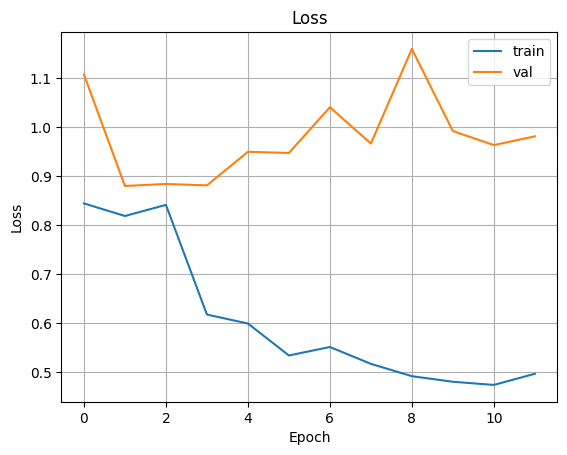

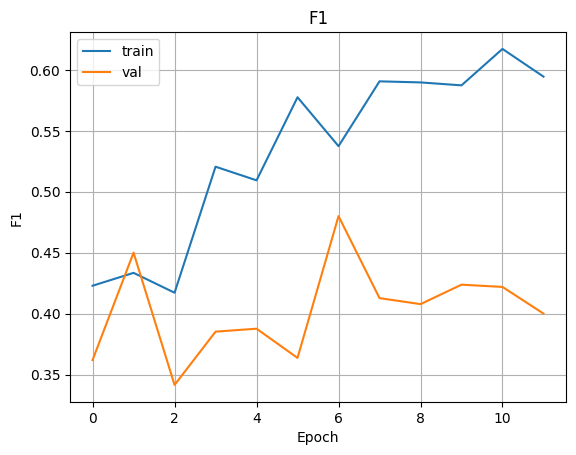

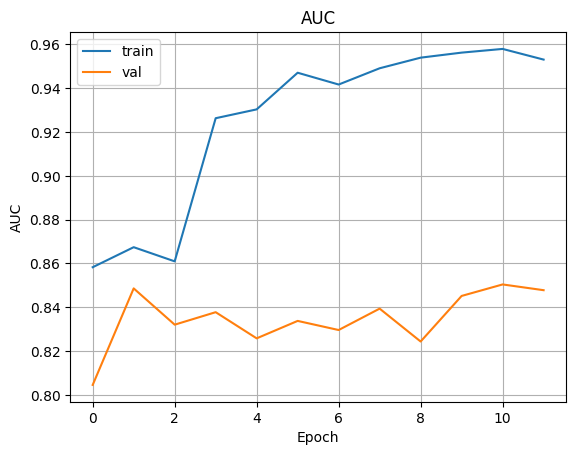

In [26]:
# Train (freeze → unfreeze) + plot metrik

WARMUP_EPOCHS = 3
TOTAL_EPOCHS  = 12  # boleh kamu ubah; mulai pendek dulu

for ep in range(1, TOTAL_EPOCHS+1):
    # unfreeze sebagian setelah warmup
    if ep == WARMUP_EPOCHS+1:
        # buka 1–2 block terakhir EfficientNet
        for p in list(model.enc.features.parameters())[-2:]:
            p.requires_grad = True
        optimizer = make_optimizer(1e-4)  # LR lebih kecil untuk fine-tune

    tr_loss, tr_f1, tr_auc = run_epoch(train_loader, True)
    va_loss, va_f1, va_auc = run_epoch(val_loader,   False)

    hist['tr_loss'].append(tr_loss); hist['va_loss'].append(va_loss)
    hist['tr_f1'].append(tr_f1);     hist['va_f1'].append(va_f1)
    hist['tr_auc'].append(tr_auc);   hist['va_auc'].append(va_auc)

    if va_auc > best['auc']:
        best['auc'] = va_auc
        best['state'] = deepcopy(model.state_dict())
        torch.save(best['state'], "/kaggle/working/effb0_bigru_best.pt")

    scheduler.step(va_auc)

    print(f"Epoch {ep:02d} | "
          f"train loss {tr_loss:.4f} f1 {tr_f1:.3f} auc {tr_auc:.3f}  ||  "
          f"val loss {va_loss:.4f} f1 {va_f1:.3f} auc {va_auc:.3f}")

# simpan log & plot
pd.DataFrame(hist).to_csv("/kaggle/working/train_log.csv", index=False)

plt.figure(); 
plt.plot(hist['tr_loss'], label='train'); plt.plot(hist['va_loss'], label='val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.figure();
plt.plot(hist['tr_f1'], label='train'); plt.plot(hist['va_f1'], label='val')
plt.title('F1'); plt.xlabel('Epoch'); plt.ylabel('F1'); plt.legend(); plt.grid(True)

plt.figure();
plt.plot(hist['tr_auc'], label='train'); plt.plot(hist['va_auc'], label='val')
plt.title('AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.legend(); plt.grid(True)
plt.show()

[VAL]  AUC=0.850 | PR-AUC real=0.588  fake=0.973
[VAL]  best macro-F1=0.761 @thr=0.85 | best FAKE-F1=0.959 @thr=0.95
[TEST] loss=1.1634  AUC=0.821  F1(macro)=0.749  F1(FAKE)=0.944  @thr=0.85

Classification report (per kelas):
              precision    recall  f1-score   support

        FAKE      0.948     0.941     0.944       307
        REAL      0.538     0.568     0.553        37

    accuracy                          0.901       344
   macro avg      0.743     0.754     0.749       344
weighted avg      0.904     0.901     0.902       344



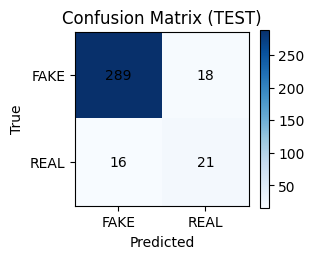

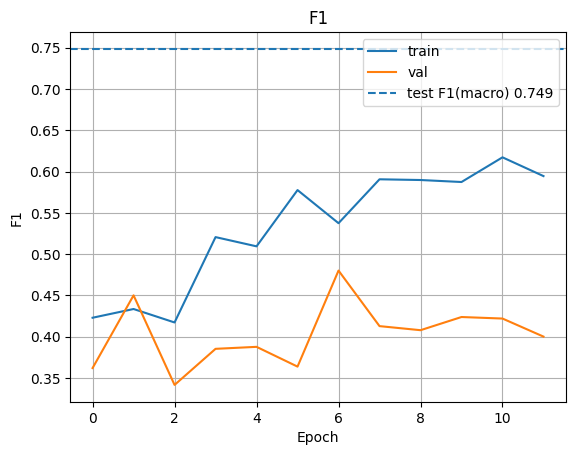

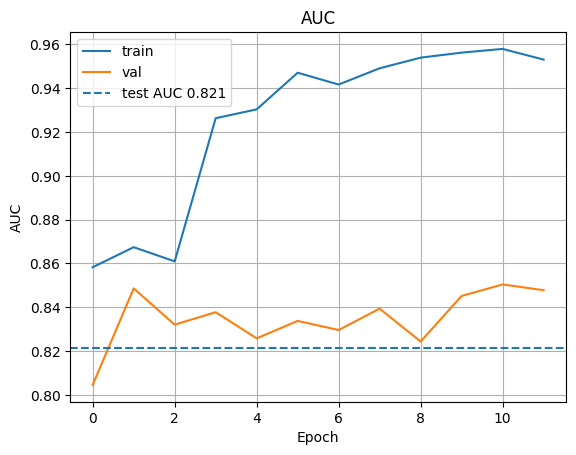

In [27]:
# ==== EVALUASI LENGKAP ====
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt

def eval_probs(loader):
    model.eval()
    losses, probs, ys = [], [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device, non_blocking=True)
            y = y.squeeze(1).to(device, non_blocking=True)
            logit = model(x); loss = criterion(logit, y)
            losses.append(loss.item())
            probs.append(torch.sigmoid(logit).cpu().numpy())
            ys.append(y.cpu().numpy())
    probs = np.concatenate(probs); ys = np.concatenate(ys)
    return float(np.mean(losses)), probs, ys

# pakai best checkpoint dari training
model.load_state_dict(torch.load("/kaggle/working/effb0_bigru_best.pt", map_location=device))

# --- pilih threshold di VALIDATION ---
va_loss, va_probs, va_y = eval_probs(val_loader)
ths = np.linspace(0.05, 0.95, 19)

macro_f1s = [f1_score(va_y, (va_probs>=t).astype(int), average='macro') for t in ths]
fake_f1s  = [f1_score(va_y, (va_probs>=t).astype(int), pos_label=0)     for t in ths]  # 0=FAKE

best_t_macro = float(ths[int(np.argmax(macro_f1s))])
best_macro   = float(np.max(macro_f1s))
best_t_fake  = float(ths[int(np.argmax(fake_f1s))])
best_fake    = float(np.max(fake_f1s))

val_auc      = float(roc_auc_score(va_y, va_probs))
pr_auc_real  = float(average_precision_score(va_y, va_probs))         # PR-AUC utk REAL (label=1)
pr_auc_fake  = float(average_precision_score(1 - va_y, 1 - va_probs)) # PR-AUC utk FAKE (label=0)

print(f"[VAL]  AUC={val_auc:.3f} | PR-AUC real={pr_auc_real:.3f}  fake={pr_auc_fake:.3f}")
print(f"[VAL]  best macro-F1={best_macro:.3f} @thr={best_t_macro:.2f} | "
      f"best FAKE-F1={best_fake:.3f} @thr={best_t_fake:.2f}")

# --- TEST sekali (pakai threshold macro-F1 dari val) ---
te_loss, te_probs, te_y = eval_probs(test_loader)
te_auc  = float(roc_auc_score(te_y, te_probs))
preds   = (te_probs >= best_t_macro).astype(int)

te_f1_macro = float(f1_score(te_y, preds, average='macro'))
te_f1_fake  = float(f1_score(te_y, preds, pos_label=0))
print(f"[TEST] loss={te_loss:.4f}  AUC={te_auc:.3f}  F1(macro)={te_f1_macro:.3f}  F1(FAKE)={te_f1_fake:.3f}  @thr={best_t_macro:.2f}")

# laporan lengkap
print("\nClassification report (per kelas):")
print(classification_report(te_y, preds, target_names=['FAKE','REAL'], digits=3))

cm = confusion_matrix(te_y, preds, labels=[0,1])
plt.figure(figsize=(3.2,3)); plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix (TEST)'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks([0,1], ['FAKE','REAL']); plt.yticks([0,1], ['FAKE','REAL'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(cm[i,j]), ha='center', va='center')
plt.colorbar(shrink=0.75); plt.tight_layout(); plt.show()

# tarik garis test di grafik F1/AUC yang sudah ada
plt.figure();
plt.plot(hist['tr_f1'], label='train'); plt.plot(hist['va_f1'], label='val')
plt.axhline(y=te_f1_macro, linestyle='--', label=f'test F1(macro) {te_f1_macro:.3f}')
plt.title('F1'); plt.xlabel('Epoch'); plt.ylabel('F1'); plt.legend(); plt.grid(True)

plt.figure();
plt.plot(hist['tr_auc'], label='train'); plt.plot(hist['va_auc'], label='val')
plt.axhline(y=te_auc, linestyle='--', label=f'test AUC {te_auc:.3f}')
plt.title('AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.legend(); plt.grid(True)
plt.show()


## Sebelumnya

In [18]:
import torch
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

GPU: Tesla P100-PCIE-16GB


#### Inference helper (1 video dir → prob REAL)

In [26]:
import torch

def predict_clip_dir(vid_dir, k=K):
    frames = sorted(glob.glob(str(Path(vid_dir)/"*.jpg")))[:k]
    while len(frames)<k: frames.append(frames[-1])
    tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(IMG_MEAN, IMG_STD)])
    imgs = [tf(Image.open(f).convert("RGB")) for f in frames]
    x = torch.stack(imgs, 0).unsqueeze(0).to(device)  # [1,T,3,224,224]
    with torch.no_grad():
        p = torch.sigmoid(model(x)).item()
    return p  # ~probability kelas 1 (REAL)

# contoh pakai salah satu folder di val:
# predict_clip_dir("/kaggle/working/faces_from_frames_224/val/FAKE/<video_id>")
